In [2]:
from detection import SubjectData
import pandas as pd
import numpy as np
from utils import train_subjects, test_subjects
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc

In [3]:
RAND_STATE = 42 

In [20]:
# This script is used to create a dataframe for the ERPP features of a subject
def get_errp_data(subject_name):
    sd = SubjectData(subject_name)
    print(f'Processing subject {subject_name}...')
    # Define feature types and channels
    feature_types = ['check', 'mean', 'peak', 'latency', 'amplitude']
    channels = range(1, 17)  # ch1 to ch16
    column_names = [f'ch{ch}_{ft}' for ch in channels for ft in feature_types]
    df = pd.DataFrame(sd.errp_features, columns=column_names)
    df.insert(0, 'subject', f'{subject_name}')  # Adds 'subject' column at position 0 ('S01')
    
    n_rows = len(df)
    # Create the S1–S5 groupings
    group_labels = ['1'] * 60 + ['2'] * 60 + ['3'] * 60 + ['4'] * 60
    remaining = n_rows - len(group_labels)
    group_labels += ['5'] * remaining  # Fill the rest with 'S5'
    # Insert after the first column (index 1)
    df.insert(1, 'session', group_labels)

    #zero_counts = (df == 0).sum()
    #print(zero_counts)
    #print(df.head())
    preds_df = pd.read_csv('./data/TrainLabels.csv', header=None)
    preds_df.columns = ['id', 'prediction']  # Rename 
    
    subject_rows = preds_df[preds_df['id'].str.contains(f'S{subject_name}')]

    predictions = subject_rows['prediction'].reset_index(drop=True)


    df = df.reset_index(drop=True)  # just in case row numbers don't match
    df['predictions'] = predictions
    
    return df

In [21]:
s2 = get_errp_data(train_subjects[0])
s6 = get_errp_data(train_subjects[1])
s7 = get_errp_data(train_subjects[2])
s11 = get_errp_data(train_subjects[3])
s12 = get_errp_data(train_subjects[4])
s13 = get_errp_data(train_subjects[5])
s14 = get_errp_data(train_subjects[6])
s16 = get_errp_data(train_subjects[7])
s17 = get_errp_data(train_subjects[8])
s18 = get_errp_data(train_subjects[9])
s20 = get_errp_data(train_subjects[10])
s21 = get_errp_data(train_subjects[11])
s22 = get_errp_data(train_subjects[12])
s23 = get_errp_data(train_subjects[13])
s24 = get_errp_data(train_subjects[14])
s26 = get_errp_data(train_subjects[15])



Processing subject 02...
Processing subject 06...
Processing subject 07...
Processing subject 11...
Processing subject 12...
Processing subject 13...
Processing subject 14...
Processing subject 16...
Processing subject 17...
Processing subject 18...
Processing subject 20...
Processing subject 21...
Processing subject 22...
Processing subject 23...
Processing subject 24...
Processing subject 26...


In [22]:
data = pd.concat([s2, s6, s7, s11, s12, s13, s14, s16, s17, s18, s20, s21, s22, s23, s24, s26], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

  subject session  ch1_check  ch1_mean   ch1_peak  ch1_latency  ch1_amplitude  \
0      02       2        1.0 -0.138034  17.128673        0.360      26.933251   
1      18       4        1.0  0.293164  53.973869        0.700      77.594126   
2      24       4        1.0 -0.068274  56.393943        0.585      74.581664   
3      13       1        0.0  0.063501  13.017165        0.920      22.579937   
4      16       2        1.0  0.075963  55.320815        0.535      80.385285   

   ch2_check  ch2_mean   ch2_peak  ...  ch15_mean   ch15_peak  ch15_latency  \
0        0.0  0.462017  14.986686  ...  -0.534328   18.942807         1.175   
1        1.0 -0.281040  46.528201  ...  -0.559510   69.643509         0.700   
2        1.0 -1.360554  42.702720  ...  -0.708993  101.118388         0.585   
3        1.0  0.212201  15.119692  ...   0.915801   11.398969         0.390   
4        1.0  0.022240  44.821729  ...   1.079642   98.621528         0.530   

   ch15_amplitude  ch16_check  ch16_me

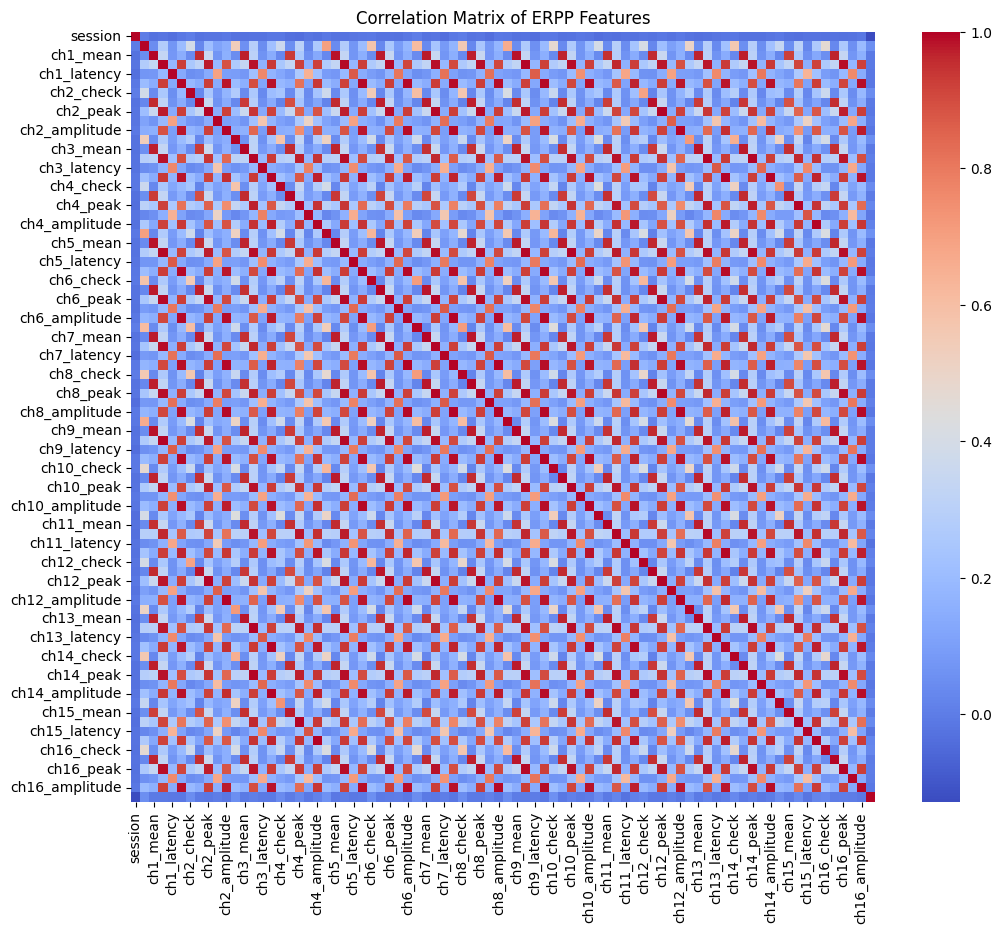

In [65]:
data_corr = data.drop(columns=['subject'])
corr_matrix = data_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of ERPP Features')
plt.show()


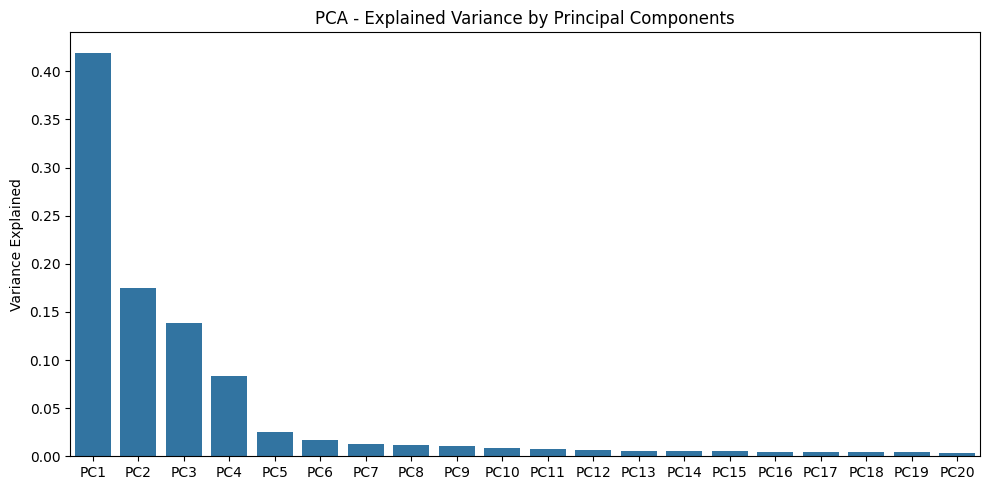

Cumulative Variance Explained:
 [0.41944711 0.59454977 0.73300521 0.8159085  0.84074365 0.85764109
 0.87075626 0.88254205 0.89347315 0.90167325 0.90897758 0.91596238
 0.92176876 0.9273815  0.93250905 0.93713366 0.94166924 0.94594948
 0.94993801 0.95383764]


In [23]:
df_numeric = data.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA(n_components=0.95)  # keep 95% of variance
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame of the principal components
pca_df = pd.DataFrame(data=principal_components,
                      columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Plot the explained variance
plt.figure(figsize=(10, 5))
sns.barplot(x=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_)
plt.ylabel('Variance Explained')
plt.title('PCA - Explained Variance by Principal Components')
plt.tight_layout()
plt.show()

# Optional: print cumulative variance explained
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("Cumulative Variance Explained:\n", cumulative_variance)

In [24]:
pca_df['subject'] = data['subject']
pca_df['session'] = data['session']
y =data['predictions']
X_train, X_val, y_train, y_val = train_test_split(pca_df, y, test_size=0.3, random_state=RAND_STATE)

In [25]:
# Define custom AUC scorer for GridSearchCV
auc_score = make_scorer(roc_auc_score, needs_proba=True)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
# Define parameter grid
rf_param_grid = {
    'n_estimators': [450, 500, 550, 600],             # Around 500
    'max_depth': [8, 10, 12],                         # Centered on 10
    'min_samples_split': [9, 11, 13],                 # Around 11
    'min_samples_leaf': [3, 4, 5]                     # Around 4
}

# Create GridSearchCV with AUC scoring
gscv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=auc_score,
    n_jobs=-1,
    verbose=1
)

# Fit on training set (e.g., with SMOTE or not)
model = gscv.fit(X_train, y_train)

# Print results
print("Random Forest")
print(f"| Best parameters: {model.best_params_}")
print(f"| Best CV AUC score: {model.best_score_:.4f}")

# Predict probabilities on validation set (positive class)
y_proba = model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
final_auc = auc(fpr, tpr)

print(f"| Final AUC on validation set: {final_auc:.4f}")
print("-" * 30)

# Optional: Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {final_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


KeyboardInterrupt: 

In [26]:
best_model = RandomForestClassifier(
    n_estimators=450,
    max_depth= 12,
    min_samples_split=13,
    min_samples_leaf=5,
    random_state=RAND_STATE
)

In [27]:
t1 = get_errp_data(test_subjects[0])
t2 = get_errp_data(test_subjects[1])
t3 = get_errp_data(test_subjects[2])
t4 = get_errp_data(test_subjects[3])
t5 = get_errp_data(test_subjects[4])
t6 = get_errp_data(test_subjects[5])
t7 = get_errp_data(test_subjects[6])
t8 = get_errp_data(test_subjects[7])
t9 = get_errp_data(test_subjects[8])
t10 = get_errp_data(test_subjects[9])

Processing subject 01...
Processing subject 03...
Processing subject 04...
Processing subject 05...
Processing subject 08...
Processing subject 09...
Processing subject 10...
Processing subject 15...
Processing subject 19...
Processing subject 25...


In [28]:
test_set= pd.concat([t1, t2, t3, t4, t5, t6, t7, t8, t9, t10], ignore_index=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
print(test_set.head())

  subject session  ch1_check  ch1_mean   ch1_peak  ch1_latency  ch1_amplitude  \
0      05       4        1.0 -0.406936  42.210586        0.490      74.104343   
1      01       2        1.0  1.334098  43.508213        0.650      71.362619   
2      08       3        1.0  1.018799  24.442537        0.405      40.855839   
3      10       5        1.0  0.128951  18.930622        0.990      34.063260   
4      25       4        1.0 -0.894682  71.985597        0.940     116.328794   

   ch2_check  ch2_mean   ch2_peak  ...  ch15_mean  ch15_peak  ch15_latency  \
0        0.0 -0.373239  37.534858  ...  -0.610923  48.318533         0.490   
1        1.0  0.422118  32.798408  ...   1.356561  69.339417         0.655   
2        1.0  0.255192  24.111517  ...   0.612880  26.581169         0.550   
3        0.0  1.880188  18.042848  ...   0.298645  26.006465         1.005   
4        1.0 -0.648209  64.473852  ...  -0.702901  93.109813         0.945   

   ch15_amplitude  ch16_check  ch16_mean  ch

In [29]:
df_numeric = test_set.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA(n_components=0.95)  # keep 95% of variance
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame of the principal components
pca_df = pd.DataFrame(data=principal_components,
                      columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

In [30]:
pca_df['subject'] = test_set['subject']
pca_df['session'] = test_set['session']

In [31]:
best_model.fit(X_train, y_train)
pred = best_model.predict_proba(pca_df)[:, 1]

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- PC21
- PC22
- PC23
- PC24


In [2]:
ids = []
for i in range(len(test_subjects)):
    name = f'S{test_subjects[i]}'
    for session in range(1, 5):
        for fid in range(1, 61):
            ids.append(f'{name}_Sess{session:02}_FB{fid:03}')
    for fid in range(1, 101):
        ids.append(f'{name}_Sess05_FB{fid:03}')
ids = np.array(ids)
print(f'ids: {ids.shape}')
print(ids)

ids: (3400,)
['S01_Sess01_FB001' 'S01_Sess01_FB002' 'S01_Sess01_FB003' ...
 'S25_Sess05_FB098' 'S25_Sess05_FB099' 'S25_Sess05_FB100']


In [ ]:
result = pd.DataFrame({
    'IdFeedback': ids,
    'Prediction': pred
})
result.to_csv('submissions/rf_pca_raw.csv', sep=',', index=False)